Este notebook tem o intuito de explorar mais relações entre os dados já processados, agora joinados em uma única tabela.

# Setting up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pathlib import Path

# current repo path 
repo_path = Path().resolve().parent

spark = SparkSession.builder.appName('Spark Demo').master('local[*]').getOrCreate()


your 131072x1 screen size is bogus. expect trouble
25/05/15 08:58:05 WARN Utils: Your hostname, George-Book3 resolves to a loopback address: 127.0.1.1; using 172.23.250.106 instead (on interface eth0)
25/05/15 08:58:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/15 08:58:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/15 08:58:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Carregando e mergeando dados

In [3]:
offers = spark.read.json((repo_path / 'data' / 'processed' / 'offers').as_posix())
transactions = spark.read.json((repo_path / 'data' / 'processed' / 'transactions').as_posix())
profiles = spark.read.json((repo_path / 'data' / 'processed' / 'profiles').as_posix())

In [4]:
offers.printSchema()
transactions.printSchema()
profiles.printSchema()

root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)

root
 |-- account_id: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- event: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- reward: double (nullable = true)
 |-- time_since_test_start: double (nullable = true)

root
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- registered_on: string (nullable = true)



como a tabela de transactions tem uma relação de mx1 tanto com offers quanto com profiles, fica claro que é mais fácil usar ela como left

In [5]:
transactions_full = (transactions
                      .join(offers, transactions['offer_id'] == offers['id'], how='left')
                      .join(profiles, transactions['account_id'] == profiles['id'], how='left')
                    )
transactions_full.show()


+--------------------+------+--------------+--------------------+------+---------------------+--------------------+--------------+--------+--------------------+---------+-------------+----+-----------------+------+--------------------+-------------+
|          account_id|amount|         event|            offer_id|reward|time_since_test_start|            channels|discount_value|duration|                  id|min_value|   offer_type| age|credit_card_limit|gender|                  id|registered_on|
+--------------------+------+--------------+--------------------+------+---------------------+--------------------+--------------+--------+--------------------+---------+-------------+----+-----------------+------+--------------------+-------------+
|78afa995795e4d85b...|  NULL|offer received|9b98b8c7a33c4b65b...|  NULL|                  0.0|[web, email, mobile]|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|  75|         100000.0|     F|78afa995795e4d85b...|   2017-05-09|


# Plots

In [38]:
temp = transactions_full.toPandas()


(-20.0, 200.0)

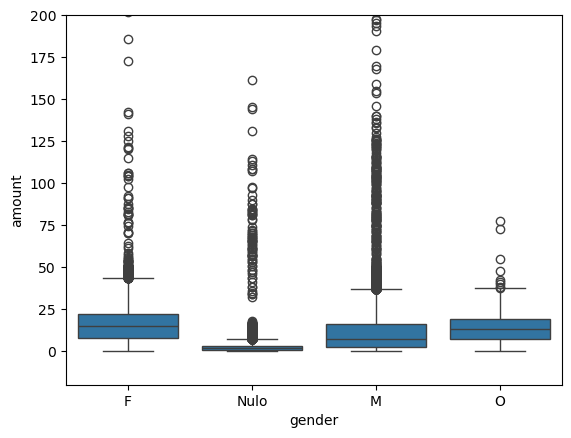

In [28]:
sns.boxplot(x = 'gender', y = 'amount', data=temp)
plt.ylim(-20,200)

Não parece ocorrer grandes siderenças entre o amount transacionado entre os gêneros (exceto pelo nulo). Há bastante outliers nos na distribuições.

<Axes: xlabel='credit_card_limit', ylabel='amount'>

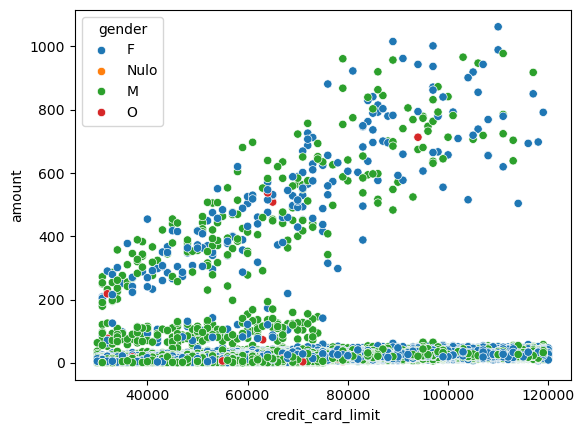

In [31]:
sns.scatterplot(x = 'credit_card_limit', y = 'amount', hue='gender' ,data=temp)


Aparenta existir uma linearidade entreo amount transacionado e o credit card limit, porém, para valores de amount baixos, eles permeiam todos os credits limits. 

<Axes: xlabel='age', ylabel='amount'>

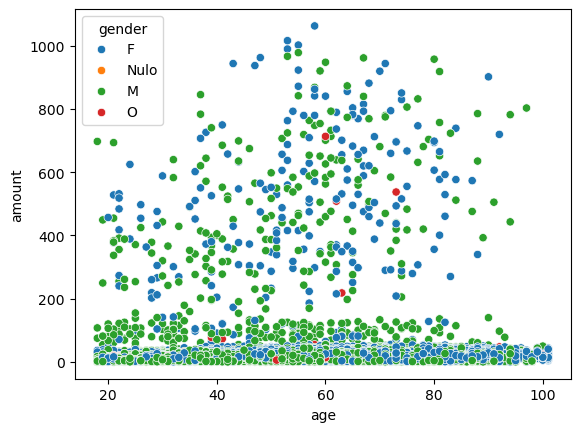

In [33]:
sns.scatterplot(x = 'age', y = 'amount', hue='gender' ,data=temp)


DIstribuição de amount com idade é bem dispersa.

<Axes: xlabel='gender', ylabel='age'>

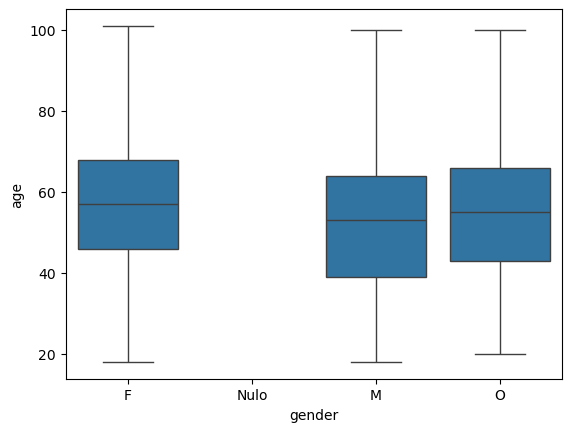

In [34]:
sns.boxplot(x = 'gender', y = 'age', data=temp)


A amostra de publico não tem diferenças de idade entre os gêneros, porém notamos que é uma população mais senior (~medianas proxima de 60 anos)

<Axes: xlabel='count', ylabel='channels'>

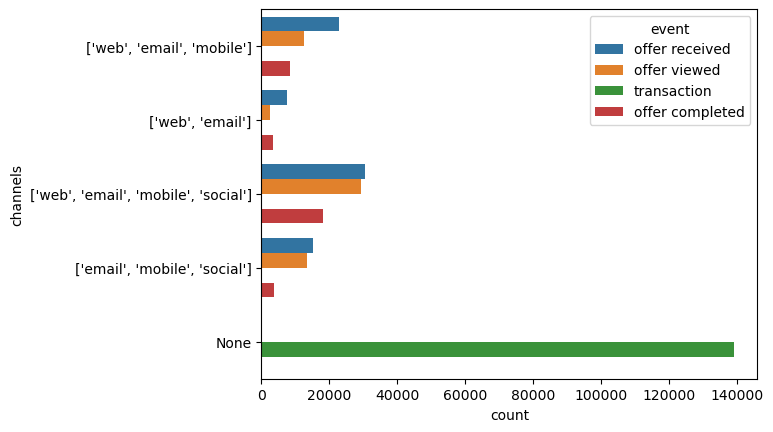

In [43]:
sns.countplot(y = 'channels', hue = 'event', data=temp.astype({'channels':str}))

Interessante notar que as ofertas completadas tem mesmo volume que as abertas, indicando uma boa aceitação da oferta, exceto nas ofertas email,mobile,social, Indicando que algo sobre essas ofertas pode ser atritoso na jornada do cliente.

<Axes: xlabel='count', ylabel='gender'>

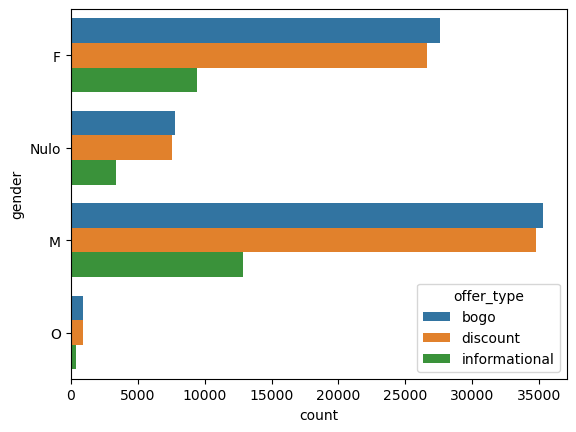

In [47]:
sns.countplot(hue = 'offer_type', y = 'gender', data=temp)

os tipos de ofertas foram enviadas na mesma proporção para os diversos gêneros

<Axes: xlabel='offer_type', ylabel='credit_card_limit'>

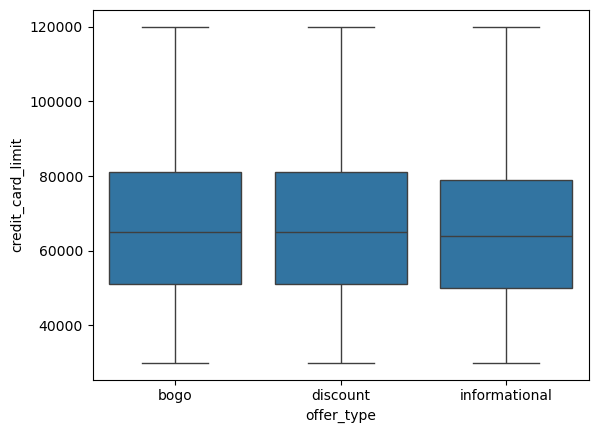

In [49]:
sns.boxplot(x = 'offer_type', y = 'credit_card_limit', data=temp)

Também não diferença entre as distribuições do limite do cartão para as diferentes offer types